## Imports and routines

In [1]:
import _init_paths
import sys
import os
import importlib
import shutil
import numpy as np
import threading
# import keras
import tqdm
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import selectivesearch
importlib.reload(selectivesearch)
from selectivesearch import get_selective_search_regions

import pickle
import PIL

import lib.utils.general; importlib.reload(lib.utils.general)
from lib.utils.general import *

import pascal_voc_reader

import bbox_transform
importlib.reload(bbox_transform)
from bbox_transform import *

import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F

import rcnn_utils
importlib.reload(rcnn_utils)
from rcnn_utils import *
import data_utils
importlib.reload(data_utils)
from data_utils import *
from nms.nms_wrapper import nms

from IPython.core.debugger import Tracer
from IPython.display import clear_output

%matplotlib inline

import voc_eval; importlib.reload(voc_eval)
from voc_eval import voc_eval

import dataset; importlib.reload(dataset); from dataset import *

In [2]:
def unnormalize_deltas(deltas, mean, std):
    ''' Unnormalize deltas using mean and std.
    Args:
        deltas: A ndarray with size (batch_size, num_fg_classes * 4)
        mean: The mean of the normalized targets
        std: The std of the normalized targets
    Returns:
        The unnormalized deltas.
    '''
    return deltas * std + mean

def dedup_boxes(boxes):
    # When mapping from image ROIs to feature map ROIs, there's some aliasing
    # (some distinct image ROIs get mapped to the same feature ROI).
    # Here, we identify duplicate feature ROIs, so we only compute features
    # on the unique subset.
    spatial_scale = 1. / 16
    v = np.array([1, 1e3, 1e6, 1e9, 1e12])
    hashes = np.round(boxes * spatial_scale).dot(v)
    _, index, inv_index = np.unique(hashes, return_index=True,
                                    return_inverse=True)
    boxes = boxes[index, :]
    return boxes, inv_index

def test_image(image, rois, targets_mean, targets_std,
               image_resize_ratio,
               top_class_only=True,
               class_detection_thresh=0.05,
               nms_thresh=0.3):
    ''' Test a single image on the net.
    Args:
        image: A preprocessed image or precomputed features of 
            the image. As ndarray.
        rois: RoIs for the image. Ndarray: (image_index, x1, y1, x2, y2)
        targets_mean: The mean of all targets.
        targets_std: The std of all targets.
        top_class_only: Whether to use only top class for each roi,
            or any class over a certain threshhold.
        class_detection_thresh: If the softmax for this class is 
            above class_detection_thresh, it's considered detected
            in the roi.
    '''
    # from CxHxW to WxHxC
    im_size = np.asarray(image.size())[::-1]

    rois_np, dedup_inv_index = dedup_boxes(rois.numpy())
    # image_var = np_to_var(image.astype(np.float32))
    # rois_var = np_to_var(rois.astype(np.int32))
    image_var = Variable(image.cuda(), volatile=True)
    rois_var = Variable(torch.Tensor(rois_np).cuda(), volatile=True)
    
    # Run the img through the network
    out = model(image_var, rois_var)
    # predicted deltas
    deltas = out[1].data.cpu().numpy()
    deltas = unnormalize_deltas(deltas, targets_mean, targets_std)

    # transform rois using predicted deltas
    boxes = rois_np[:, 1:] / image_resize_ratio
    bboxes_inv_transformed = bbox_transform_inv(boxes, deltas)

    class_probas, class_indexes = torch.max(out[0], 1)
    indexes_np = np.squeeze(class_indexes.data.cpu().numpy())
#     print('Total FG RoIs Detected: ', np.sum(indexes_np > 0))

    scores = out[0].data.cpu().numpy()
    scores = np.exp(scores)

    # clip rois to image size
    bboxes_inv_transformed = clip_boxes(bboxes_inv_transformed,
                                        im_size)
    
    scores = scores[dedup_inv_index, :]
    bboxes_inv_transformed = bboxes_inv_transformed[dedup_inv_index, :]
    
    # Non-maximum supression of similar boxes
    all_boxes = nms_boxes(bboxes_inv_transformed, scores,
                          top_class_only=top_class_only,
                          class_detection_thresh=class_detection_thresh,
                          nms_thresh=nms_thresh)


    return all_boxes


def nms_boxes(boxes, scores, num_classes=21,
              top_class_only=False,
              class_detection_thresh=0.05,
              nms_thresh=0.3):
    all_boxes = [[] for _ in range(num_classes)]
    # skip j = 0, because it's the background class
    for class_id in range(1, num_classes):
        # Whether to use only the top class for each box or
        # all classes over a certain threshhold.
        if top_class_only:
            detection_criterion = (np.argmax(scores, axis=1) == class_id)
        else:
            detection_criterion = (
                scores[:, class_id] > class_detection_thresh)
        class_detected_indexes = np.where(detection_criterion)[0]

        cls_scores = scores[class_detected_indexes, class_id]
        class_box_start = (class_id) * 4
        class_box_end = class_box_start + 4
        cls_boxes = boxes[class_detected_indexes,
                          class_box_start:class_box_end]

        cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
            .astype(np.float32, copy=False)

        if len(cls_dets) > 1:
            keep = nms(cls_dets, nms_thresh, force_cpu=True)
            cls_dets = cls_dets[keep, :]
        all_boxes[class_id] = cls_dets
    return all_boxes


def get_display_boxes(all_boxes):
    display_boxes = []
    display_classes = []
    for class_id, class_boxes in enumerate(all_boxes):
        for box in class_boxes:
            display_boxes.append(box)
            display_classes.append(class_id)
    return np.asarray(display_boxes), np.asarray(display_classes)


def display_detections(rois, classes, sample, 
                       show_gt_boxes=True, 
                       class_id_to_name=None, 
                       resize_image=True):
    ''' Display detected foreground rois for a sample.
    Args:
        rois: Detected RoIs as ndarray of (x, y, w, h)
        classes: Class labels of each RoI as ndarray of class_id.
        sample: A dict describing the sample that produced 
            the rois and classes.
        show_gt_boxes: Show the ground truth boxes as well.
        class_id_to_name: A dict mapping from a class id to a class name.
    '''
    detected_roi = np.append(rois,
                             classes[:, None],
                             axis=1)
    if show_gt_boxes:
        gt_boxes = sample['gt_boxes_xywh'] / sample['resize_ratio']
    else:
        gt_boxes = None

    if resize_image:
        image = Pascal_VOC.get_image(sample)
    else:
        image = PIL.Image.open(sample['filepath'])
        
    for class_id in detected_roi[:, 5]:
        print(class_id_to_name[class_id])
    display_image_regions(image, detected_roi, gt_boxes,
                          class_id_to_name=class_id_to_name)

## Load data

In [3]:
def load_data():
    data_set = Pascal_VOC(data_path='../VOC/VOCdevkit/',
                          year='2007', set_name='test',
                          mode='test')

    dataloader = torch.utils.data.DataLoader(
        data_set, batch_size=1, shuffle=False, num_workers=3)

    data_iter = dataloader.__iter__()
    return data_set, dataloader, data_iter


try:
    del data_set
    del dataloader
    del data_iter
except:
    pass

data_set, dataloader, data_iter = load_data()

## Setup the network

In [24]:
# Init the model
try:
    del model
except NameError:
    pass

model = Fast_RCNN_model(dropout_p=0.5).cuda()
model.train(mode=False)
# fast_rcnn_weights_init(model)
load_weights(model, 'intermediate/voc/weights-sgd-improved-210k.pth')# weights-sgd-improved-80k.pth')

## Test a single image 

In [5]:
data_iter = dataloader.__iter__()

000010.jpg
horse
person
person
pottedplant


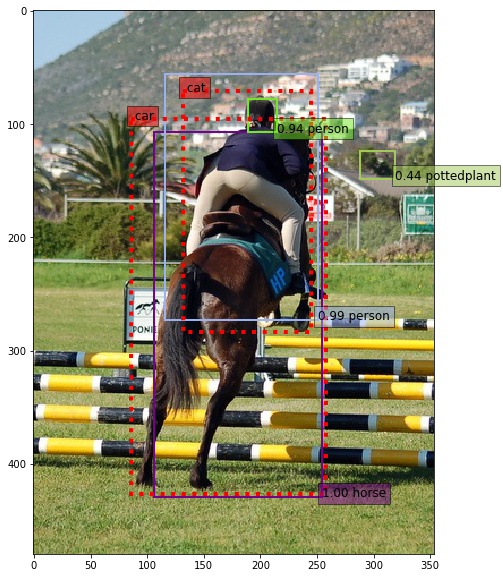

In [13]:
batch = next(data_iter)
sample_index, images, rois, = batch
sample_index = sample_index.cpu().numpy()[0]

image_resize_ratio = data_set.samples[sample_index]['resize_ratio']

all_boxes = test_image(images, rois[0], 
                       targets_mean=data_set.targets_mean, 
                       targets_std=data_set.targets_std, 
                       image_resize_ratio=image_resize_ratio,
                       top_class_only=False,
                       class_detection_thresh=0.3, 
                       nms_thresh=0.15)

display_boxes, display_classes = get_display_boxes(all_boxes)
print(data_set.samples[sample_index]['filename'])
if len(display_boxes) == 0:
    print('Nothing detected for this image.')
else:
    display_detections(
        x1y1x2y2_to_xywh(display_boxes),
        display_classes,
        data_set.samples[sample_index], 
        show_gt_boxes=True, 
        resize_image=False,
        class_id_to_name=rbg_class_id_to_name)

##  Test all images

In [25]:
def test(dataloader):

    n_batches = len(dataloader.dataset.samples) // 2
    
    all_boxes = [[[] for _ in range(n_batches)]
                 for _ in range(dataloader.dataset.num_classes)]
    data_iterator = dataloader.__iter__()
    for image_index in tqdm.tqdm_notebook(range(n_batches)):
        # Get next batch
        try:
            batch = next(data_iterator)
        except StopIteration:
            break
        sample_index, images, rois,  = batch
        sample_index = sample_index.cpu().numpy()[0]
        image_resize_ratio = data_set.samples[sample_index]['resize_ratio']

        # Forward Pass
        image_boxes = test_image(images, rois[0], 
                               targets_mean=dataloader.dataset.targets_mean, 
                               targets_std=dataloader.dataset.targets_std, 
                               image_resize_ratio=image_resize_ratio,
                               top_class_only=False,
                               class_detection_thresh=0.05, 
                               nms_thresh=0.3)
        
        for class_id, class_boxes in enumerate(image_boxes):
            all_boxes[class_id][image_index] = class_boxes

    return all_boxes

In [26]:
all_boxes = test(dataloader)

In [33]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, 'test-detections-sgd-improved-210k.pkl')
with open(det_file, 'wb') as f:
    pickle.dump(all_boxes, f, protocol=1) #pickle.HIGHEST_PROTOCOL)


In [196]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, 'detections.pkl')
with open(det_file, 'rb') as f:
    all_boxes = pickle.load(f)


## Compare RGB and mine

In [268]:
output_dir = 'intermediate/voc/'
det_file = os.path.join(output_dir, 'detections-sgd-80k.pkl')
with open(det_file, 'rb') as f:
    all_boxes = pickle.load(f)


In [34]:
output_dir = '../rbgirshick/py-faster-rcnn/output/default/voc_2007_test/vgg16_fast_rcnn_iter_40000/'
det_file = os.path.join(output_dir, 'detections.pkl')
with open(det_file, 'rb') as f:
    rbg_boxes = pickle.load(f, encoding='latin1')

In [35]:
# _classes = [data_set.class_id_to_name[index] 
#             for index in range(data_set.num_classes)]
_devkit_path = '../VOC/VOCdevkit/'

In [36]:
rbg_classes = ('__background__',  # always index 0
            'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor')
rbg_class_name_to_id = dict(zip(rbg_classes, range(len(rbg_classes))))
rbg_class_id_to_name = {v:k for k,v in rbg_class_name_to_id.items()}

In [37]:
# class_id = class_name_to_id['car']
# detections = [class_detections[sample_index]
#               for class_detections in all_boxes]

def display_image_boxes(sample_index, all_boxes, class_id_to_name,
                       resize_image=True):
    image_rois = [class_detections[sample_index]
              for class_detections in all_boxes]

    image_rois_list = []
    image_classes = []
    for class_index, class_rois in enumerate(image_rois):
        if len(class_rois) > 0:
            classes = np.ones((class_rois.shape[0])) * class_index
            image_rois_list.extend(class_rois)
            image_classes.extend(classes)
    image_rois_list = np.array(image_rois_list)
    image_classes = np.array(image_classes)
    # only show gt boxes on resized image
    show_gt_boxes = False
    display_detections(
        x1y1x2y2_to_xywh(image_rois_list),
        image_classes,
        data_set.samples[sample_index], 
        show_gt_boxes=show_gt_boxes, 
        class_id_to_name=class_id_to_name,
        resize_image=resize_image)


In [39]:
sample_index -= 1
sample_index

Mine
chair
chair
chair
chair
chair
chair
diningtable
pottedplant
pottedplant
sofa
sofa
tvmonitor


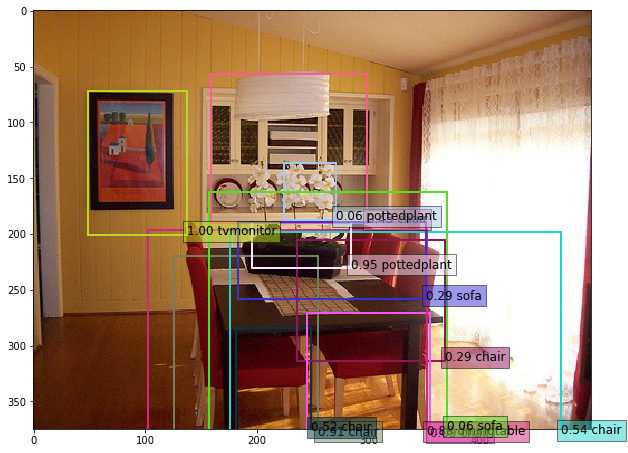

RBG
chair
chair
chair
chair
chair
chair
diningtable
person
pottedplant
sofa
tvmonitor


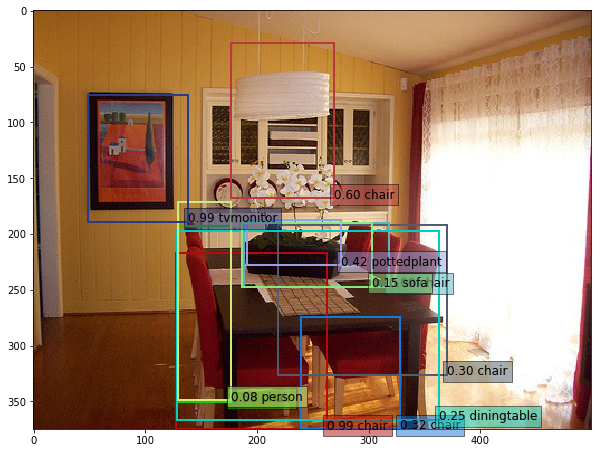

Done


In [43]:
sample_index += 1
print('Mine')
display_image_boxes(sample_index, all_boxes, data_set.class_id_to_name, 
                    resize_image=False)
print('RBG')
display_image_boxes(sample_index, rbg_boxes, rbg_class_id_to_name, 
                    resize_image=False)
print('Done')

## Eval results

In [7]:
non_flipped_len = len(data_set.filenames) // 2
dataset_filenames = np.array(data_set.filenames[:non_flipped_len])
names_only = [name.replace('./data/VOC2007/JPEGImages/',''
                          ).replace('.jpg', '')
              for name in dataset_filenames]
len(names_only)

4952

In [8]:
# imageset_filename = 'slav_train.txt'
# save_dir = 'data/VOCdevkit/VOC2012/ImageSets/Main/'
# fullpath = os.path.join(save_dir, imageset_filename)
# with open(fullpath, 'w') as f:
#     for line in names_only:
#         f.write('{:s}\n'.format(line))

In [9]:
def _write_voc_results_file(classes, filenames, all_boxes, _devkit_path):
    for cls_ind, cls in enumerate(classes):
        if cls == '__background__':
            continue
        print('Writing {} VOC results file'.format(cls))
        filename = _get_voc_results_file_template(_devkit_path).format(cls)
        with open(filename, 'wt') as f:
            for im_ind, index in enumerate(filenames):
                dets = all_boxes[cls_ind][im_ind]
                if dets == []:
                    continue
                # the VOCdevkit expects 1-based indices
                for k in range(dets.shape[0]):
                    f.write('{:s} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.
                            format(index, dets[k, -1],
                                   dets[k, 0] + 1, dets[k, 1] + 1,
                                   dets[k, 2] + 1, dets[k, 3] + 1))


In [10]:
def _get_voc_results_file_template(_devkit_path):
    # VOCdevkit/results/VOC2007/Main/<comp_id>_det_test_aeroplane.txt
    filename = '_det_' + 'trainval' + '_{:s}.txt'
    path = os.path.join(
        _devkit_path,
        'results',
        'VOC2007',
        'Main',
        filename)
    return path


In [11]:
def _do_python_eval(_devkit_path, _classes, output_dir = 'output', 
                   imageset_filename='trainval.txt'):
    annopath = os.path.join(
        _devkit_path,
        'VOC2007',
        'Annotations',
        '{:s}.xml')
    imagesetfile = os.path.join(
        _devkit_path,
        'VOC2007',
        'ImageSets',
        'Main',
        imageset_filename)

    cachedir = os.path.join(_devkit_path, 'annotations_cache')
    aps = []
    # The PASCAL VOC metric changed in 2010
    use_07_metric = True

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i, cls in enumerate(_classes):
        if cls == '__background__':
            continue
        filename = _get_voc_results_file_template(_devkit_path).format(cls)
        rec, prec, ap = voc_eval(
            filename, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
            use_07_metric=use_07_metric)
        aps += [ap]
        print('AP for {} = {:.4f}'.format(cls, ap))
        with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
            pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)
    print('Mean AP = {:.4f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('Results:')
    for ap in aps:
        print('{:.3f}'.format(ap))
    print('{:.3f}'.format(np.mean(aps)))
    print('~~~~~~~~')
    print('')
    print('--------------------------------------------------------------')
    print('Results computed with the **unofficial** Python eval code.')
    print('Results should be very close to the official MATLAB eval code.')
    print('Recompute with `./tools/reval.py --matlab ...` for your paper.')
    print('-- Thanks, The Management')
    print('--------------------------------------------------------------')


In [44]:
_write_voc_results_file(rbg_classes, names_only, rbg_boxes, _devkit_path)

Writing aeroplane VOC results file
Writing bicycle VOC results file
Writing bird VOC results file

/home/slav/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.



Writing boat VOC results file
Writing bottle VOC results file
Writing bus VOC results file
Writing car VOC results file
Writing cat VOC results file
Writing chair VOC results file
Writing cow VOC results file
Writing diningtable VOC results file
Writing dog VOC results file
Writing horse VOC results file
Writing motorbike VOC results file
Writing person VOC results file
Writing pottedplant VOC results file
Writing sheep VOC results file
Writing sofa VOC results file
Writing train VOC results file
Writing tvmonitor VOC results file


In [45]:
imageset_filename = 'test.txt'
_do_python_eval(_devkit_path, rbg_classes, 
                imageset_filename=imageset_filename)

AP for aeroplane = 0.7447
AP for bicycle = 0.7885
AP for bird = 0.6735
AP for boat = 0.5570
AP for bottle = 0.3995
AP for bus = 0.7711
AP for car = 0.7837
AP for cat = 0.7950
AP for chair = 0.4770
AP for cow = 0.7398
AP for diningtable = 0.6890
AP for dog = 0.7719
AP for horse = 0.7808
AP for motorbike = 0.7520
AP for person = 0.7206
AP for pottedplant = 0.3207
AP for sheep = 0.6659
AP for sofa = 0.6723
AP for train = 0.7443
AP for tvmonitor = 0.6493
Mean AP = 0.6748
~~~~~~~~
Results:
0.745
0.789
0.674
0.557
0.399
0.771
0.784
0.795
0.477
0.740
0.689
0.772
0.781
0.752
0.721
0.321
0.666
0.672
0.744
0.649
0.675
~~~~~~~~

--------------------------------------------------------------
Results computed with the **unofficial** Python eval code.
Results should be very close to the official MATLAB eval code.
Recompute with `./tools/reval.py --matlab ...` for your paper.
-- Thanks, The Management
--------------------------------------------------------------
